# Image Classification

Preprocessing -> Feature Extraction -> Training

## Case Study: Parkinsons Detection

https://www.pyimagesearch.com/2019/04/29/detecting-parkinsons-disease-with-opencv-computer-vision-and-the-spiral-wave-test/

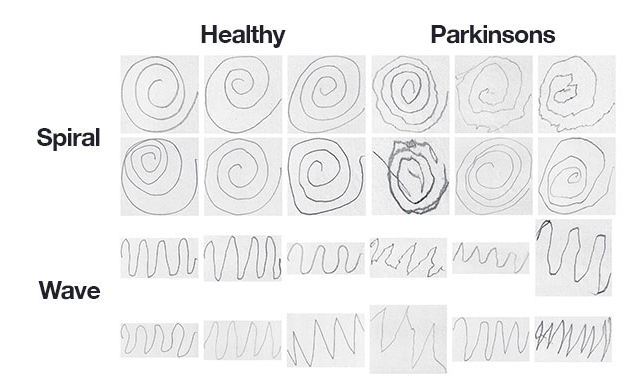

In [214]:
from skimage import feature
from imutils import paths
import numpy as np
import argparse
import cv2 as cv
import os
import pandas as pd
from google.colab.patches import cv2_imshow

## Metode preprocessing

In [215]:
def preprocess(image, image_size=128):
		image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) # Ubah mehjadi grayscale
		image = cv.resize(image, (image_size, image_size)) # Resize gambar menjadi suatu ukuran (default = 128)

		image = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1] # Melakukan thresholding dan mengambil hasil gambar thresholding

		return image

## Feature Extraction

Mengekstrak feature dari gambar menggunakan image descriptor.

Beberapa contoh image descriptor:
  - Histogram of Oriented Gradients (HOG)
  - Local Binary Pattern (LBP)

#### HOG

https://gurus.pyimagesearch.com/lesson-sample-histogram-of-oriented-gradients-and-car-logo-recognition/#tour_modal


Berfungsi untuk mendeteksi perubahan intensitas/warna untuk mengidentifikasi bentuk/tekstur. Menghasilkan feature vector dengan ukuran yang relatif besar.

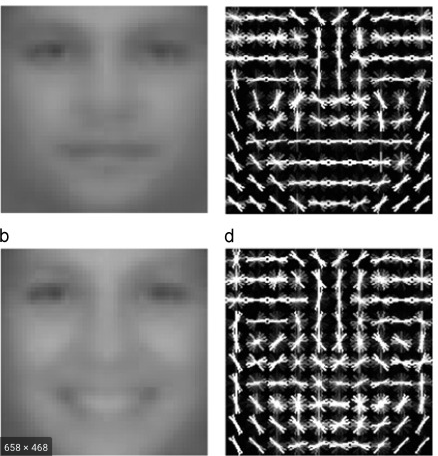

https://www.sciencedirect.com/science/article/abs/pii/S0925231215014812

In [216]:
# From: https://www.pyimagesearch.com/2019/04/29/detecting-parkinsons-disease-with-opencv-computer-vision-and-the-spiral-wave-test/
def quantify_image_hog(image): # Histogram of Oriented Gradient features
	features = feature.hog(image, orientations=9, pixels_per_cell=(10, 10), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")

	return features

#### Local Binary Patterns
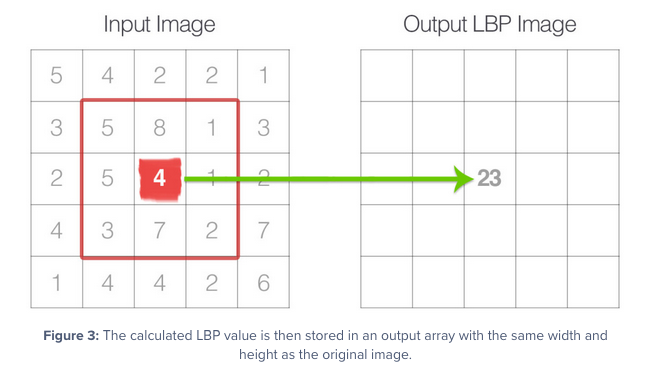

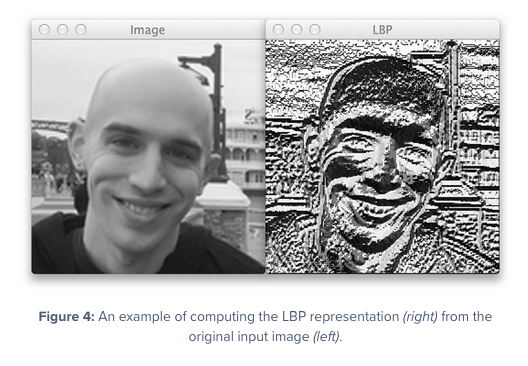

Berfungsi untuk mendeteksi perubahan intensitas/warna untuk mengidentifikasi bentuk/tekstur. Menghasilkan feature vector dengan ukuran lebih kecil dari HOG.

https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/


In [217]:
# From: https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/
def quantify_image_lbp(image): # Local Binary Pattern features
  features = feature.local_binary_pattern(image, 24, 8, method="uniform")

  (hist, _) = np.histogram(features.flatten(), bins=np.arange(0, 27), range=(0, 26))

  hist = hist.astype("float")
  hist /= (hist.sum() + 1e-7)

  return hist

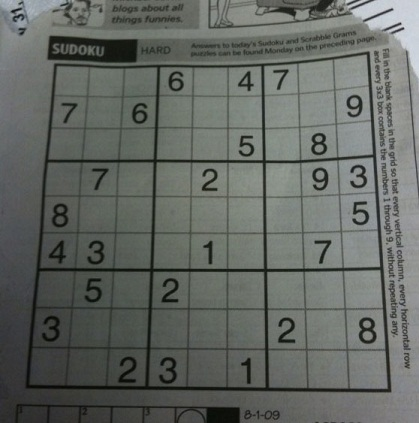

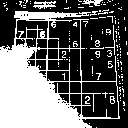

HOG
[0.18207233 0.         0.06866378 ... 0.03804243 0.         0.        ] 4356
LBP
[1.27563477e-02 2.24609375e-02 1.52587891e-03 8.54492187e-04
 8.54492187e-04 9.76562500e-04 4.88281250e-04 1.22070312e-03
 1.03759766e-03 1.83105469e-03 2.01416016e-03 1.77001953e-03
 1.95312500e-03 2.55126953e-02 1.46484375e-03 9.15527344e-03
 1.22070312e-03 1.73339844e-02 1.83105469e-03 1.10473633e-02
 2.38037109e-03 1.10473633e-02 1.95312500e-03 9.27734375e-03
 7.16064453e-01 1.41967773e-01] 26


In [218]:
# Test

image_test = cv.imread('drive/My Drive/Bootcamp_Images/sudoku.png')

image_test_preprocessed = preprocess(image_test, image_size=128)

cv2_imshow(image_test)
cv2_imshow(image_test_preprocessed)

features_hog = quantify_image_hog(image_test_preprocessed)
features_lbp = quantify_image_lbp(image_test_preprocessed)

print("HOG")
print(features_hog, len(features_hog))
print("LBP")
print(features_lbp, len(features_lbp))

### Split Dataset

In [219]:
def load_split(path, image_size=200, extraction_method='hog'):
	image_paths = list(paths.list_images(path))
	data = []
	labels = []

	for image_path in image_paths:
		label = image_path.split(os.path.sep)[-2]

		image = cv.imread(image_path)
		image = preprocess(image, image_size=image_size)
		
		if extraction_method == 'hog':
			features = quantify_image_hog(image)
		elif extraction_method == 'lbp':
			features = quantify_image_lbp(image)

		data.append(features)
		labels.append(label)

	return (np.array(data), np.array(labels))

### Load dataset

In [220]:
dataset_dir = '/content/drive/My Drive/Bootcamp_Images/parkinsons/spiral'

trainingPath = os.path.join(dataset_dir, "training")
testingPath = os.path.join(dataset_dir, "testing")

### Set ukuran image yang dipakai untuk resize & metode feature extraction

In [221]:
resize_image_size = 128 # Masing-masing gambar perlu diresize menjadi suatu ukuran yang tetap
extraction_method = 'hog' # 'lbp' atau 'hog'

### Split Dataset

In [222]:
(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)

print("Data loaded!")

Data loaded!


### Encode label (0 = healthy, 1 = parkinsons)

In [223]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)

In [224]:
label_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [225]:
label_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [226]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

### Logistic Regression

In [227]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(feature_train, label_train)
predictions = logreg.predict(feature_test)

classification_report(label_test, predictions)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(feature_test, label_test))) # .score() -> Accuracy
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

Accuracy of logistic regression classifier on test set: 0.77
F1 0.7664071190211346
Precision 0.7678571428571428
Recall 0.7666666666666666


### SVM

In [228]:
from sklearn.svm import SVC
classifier_rbf = SVC(kernel = "rbf")
classifier_rbf.fit(feature_train, label_train)
predictions = classifier_rbf.predict(feature_test)

classification_report(label_test, predictions)
print('Accuracy of SVM on test set: {:.2f}'.format(classifier_rbf.score(feature_test, label_test)))
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

Accuracy of SVM on test set: 0.80
F1 0.7991071428571428
Precision 0.8054298642533937
Recall 0.8


### Random Forest

In [229]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=10)
model.fit(feature_train, label_train)

predictions = model.predict(feature_test)

classification_report(label_test, predictions)

print(pd.crosstab(label_test, predictions, rownames=['True'], colnames=['Predicted'], margins=True))

Predicted   0   1  All
True                  
0          13   2   15
1           6   9   15
All        19  11   30


In [230]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

print(classification_report(label_test, predictions))

print('Accuracy of Random Forest on test set: {:.2f}'.format(model.score(feature_test, label_test)))
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

              precision    recall  f1-score   support

           0       0.68      0.87      0.76        15
           1       0.82      0.60      0.69        15

    accuracy                           0.73        30
   macro avg       0.75      0.73      0.73        30
weighted avg       0.75      0.73      0.73        30

Accuracy of Random Forest on test set: 0.73
F1 0.7285067873303168
Precision 0.7511961722488039
Recall 0.7333333333333334


In [231]:
testing_paths = list(paths.list_images(testingPath))
images = []

for testing_path in testing_paths[:25]:
	image = cv.imread(testing_path)
	output = image.copy()
	output = cv.resize(output, (128, 128))

	image = preprocess(image, image_size=resize_image_size)

	if extraction_method == 'hog':
		features = quantify_image_hog(image)
	elif extraction_method == 'lbp':
		features = quantify_image_lbp(image)
   
	preds = model.predict([features])
	label = le.inverse_transform(preds)[0]

	color = (0, 255, 0) if label == "healthy" else (0, 0, 255)
	cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
	images.append(output)

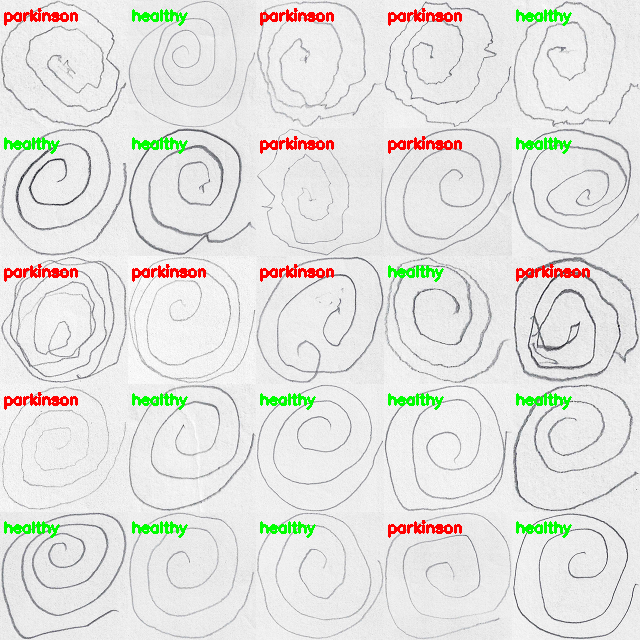

In [232]:
from imutils import build_montages

montage = build_montages(images, (128, 128), (5, 5))[0]

cv2_imshow(montage)

# Assignment

1. Gunakan kombinasi berikut untuk dataset wave:
  - Feature extractor HOG dengan image size 128 dan 300
  - Feature extractor LBP dengan image size 128 dan 300

  Masing-masing kombinasi dilakukan training dengan 3 algoritma:
    - LinearSVC
    - Logistic Regression
    - Random Forest
  Gunakan random_state=10 apabila dibutuhkan!

  Lakukan eksperimen terhadap hyperparameter sesuai kebutuhan dan tentukan komposisi mana yang dapat menghasilkan accuracy dan F1 score tertinggi! Berikan kesimpulan dan jelaskan!

2. Lanjutkan untuk dataset wave:
  - Ambilah secarik kertas dan buatlah 30 data tambahan untuk training dengan komposisi:
    - 15 healthy (dengan gambar wave yang rapih)
    - 15 parkinson (dengan gambar wave yang lebih ireguler)
  - Lakukan training dengan komposisi feature extractor, ukuran gambar, algoritma, serta hyperparameter terbaik yang didapat untuk nomor 1!

  Jelaskan, apakah terdapat perbedaan dalam hasil evaluasi training setelah ditambahkan data baru?